In [1]:
%matplotlib inline

In [2]:
from __future__ import division

In [131]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh, dijkstra, shortest_path, sorted_path
from plotting import plot_surf_stat_map, plot_surf_label
from jensen_shannon import jensenshannon
from scipy.signal import argrelmax
from mapalign import dist as mdist
from mapalign import embed as membed
import pickle
import operator

In [4]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

In [5]:
def kmeans(embedding,n_components):
    import numpy as np
    from sklearn.cluster import KMeans
    
    est = KMeans(n_clusters=n_components, n_jobs=-2, init='k-means++', n_init=300)
    est.fit_transform(embedding)
    labels = est.labels_
    kmeans_results = labels.astype(np.float)
    kmeans_results += 1
    return kmeans_results

In [396]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    data = data.flatten()
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
    if bins == 'auto':
        bins = data.shape[0]/10
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    return p_mass, x_values

def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/10))
    p_mass = np.zeros((len(data), bins))
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    if weights is None:
        weights = 1/len(data)
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    jsdistance = np.sqrt(jsdivergence)
    return jsdivergence, jsdistance

In [388]:
def make_div_cmap(c):
    cmap= np.asarray(sns.diverging_palette(240, 15, n=c, center='dark'))
    #cmap = np.concatenate((np.array([[0.8,0.8,0.8,1]]), cmap), axis=0)
    #cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [7]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
fc_embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10.npy'
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_profiles.npy'
windows_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/windows_longpath3_rad4.pkl'
corr_dict_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/corr_windows_longpath3_rad4.pkl'

In [8]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)[:,3:8]
fc_embed = np.load(fc_embed_file)
with open(windows_file, 'r') as pkl_in:
    windows = pickle.load(pkl_in)
with open(corr_dict_file, 'r') as pkl_in:
    corr_dict = pickle.load(pkl_in)

In [167]:
corr_dict={}
for window in windows:
    for w in window:
        corr_dict[w]=full_corr[w]
with open('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/corr_windows_longpath2_rad4.pkl', 'w') as pkl_out:
    pickle.dump(corr_dict, pkl_out)

(75589,)

In [9]:
halfwidth = 2
overlap = 0

In [10]:
combined_windows=[]
for window in np.arange(start=halfwidth, stop=len(windows)-halfwidth, step=2*halfwidth-overlap):
    combined_window=[]
    for k in range(window-halfwidth,window+halfwidth):
        combined_window+=windows[k]
    combined_windows.append(combined_window)

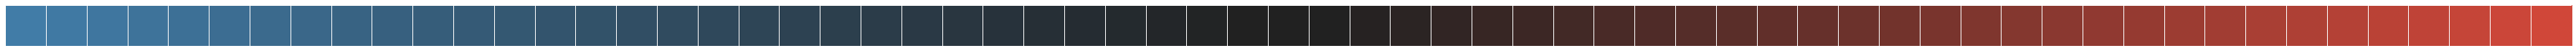

In [11]:
eta_cmap, eta_cmap_255 = make_div_cmap(len(combined_windows))
sns.palplot(eta_cmap)

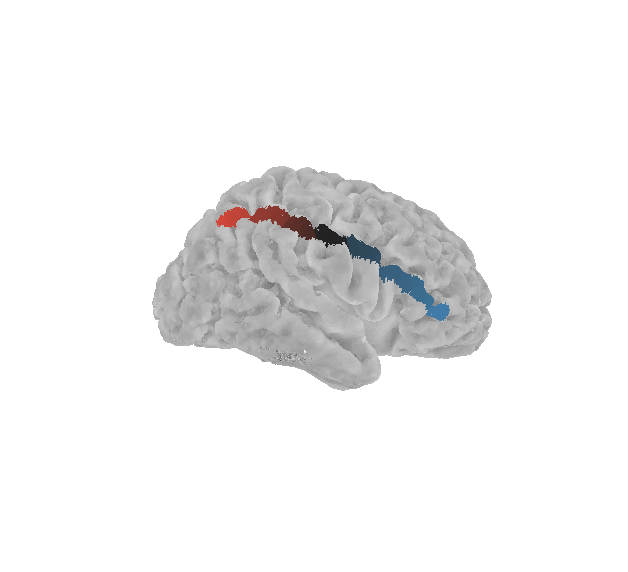

In [24]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(combined_windows), cpal=eta_cmap, bg_map=sulc, 
                        elev=180,azim=0, figsize=(11,10), darkness=0.8)

In [12]:
#combined_windows=combined_windows[35:]

In [11]:
fullpath=[]
for window in combined_windows:
    fullpath+=window
fullpath=np.unique(fullpath)

In [12]:
cheb_windows=[]
cheb_avg=[]
for window in combined_windows:
    coeff, poly = chebapprox(profiles[window], degree=4)
    cheb_windows.append(coeff)
    cheb_avg.append(np.mean(coeff, axis=0))
cheb_avg = np.nan_to_num(np.asarray(cheb_avg))

cheb_avg_affinity = mdist.compute_affinity(cheb_avg)
cheb_avg_embed = membed.compute_diffusion_map(cheb_avg_affinity, n_components=10)

In [13]:
corr_windows=[]
corr_avg=[]
for window in combined_windows:
    warray = np.zeros((len(window), len(fullpath)))
    for w in range(len(window)):
        warray[w]=np.nan_to_num(corr_dict[window[w]][fullpath])
    corr_windows.append(warray)
    corr_avg.append(np.tanh(np.mean(np.arctanh(warray), axis=0)))
corr_avg = np.nan_to_num(np.asarray(corr_avg))

corr_avg_affinity = mdist.compute_affinity(corr_avg)
corr_avg_embed = membed.compute_diffusion_map(corr_avg_affinity, n_components=10)

In [14]:
sulc_windows=[]
sulc_avg=[]
for window in combined_windows:
    sulc_windows.append(sulc[window])
    sulc_avg.append(np.mean(sulc[window], axis=0))

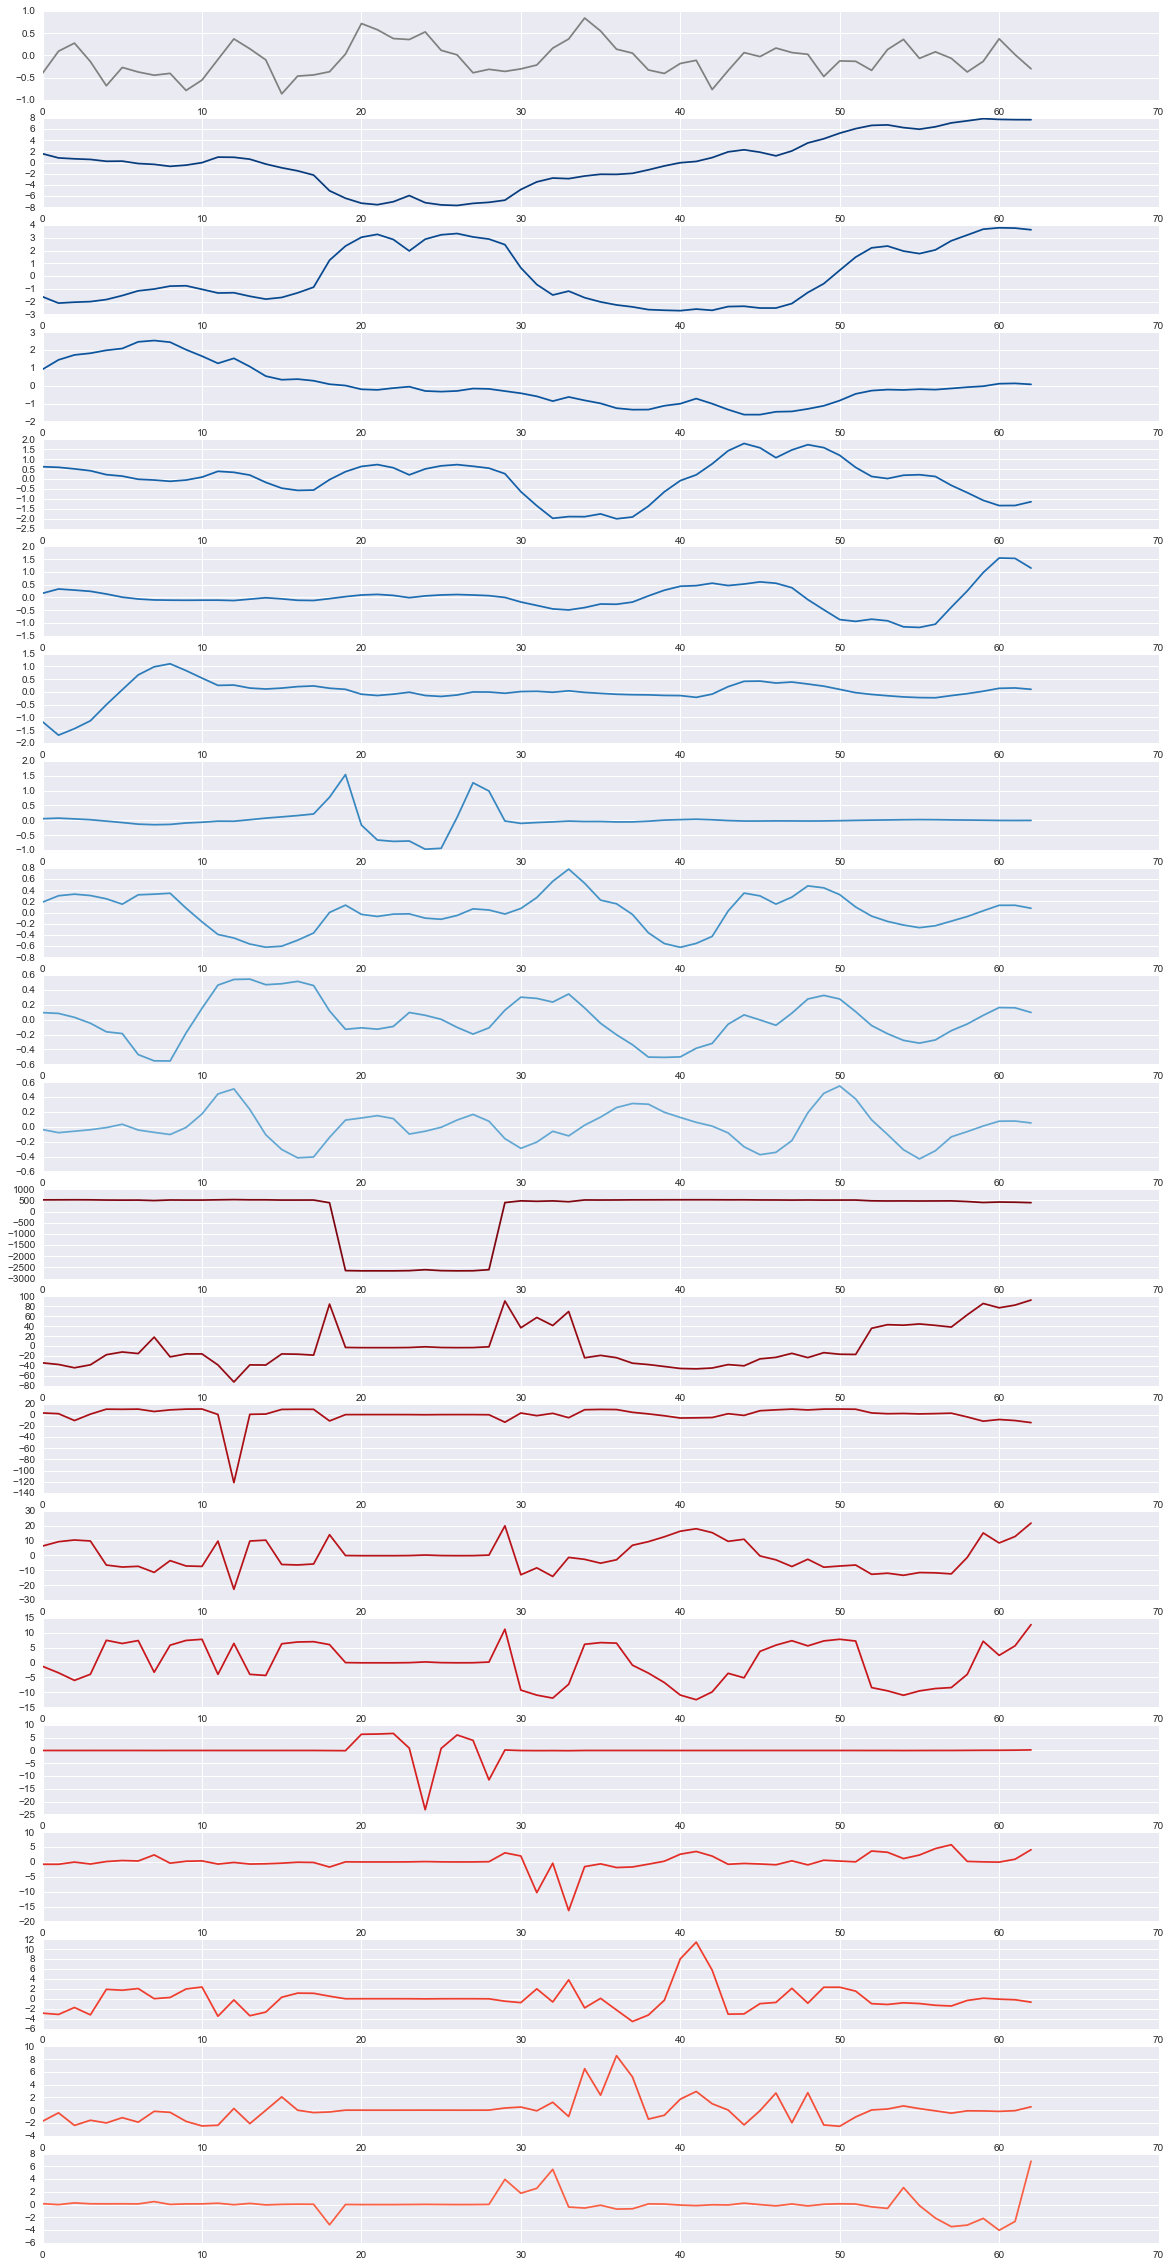

In [15]:
sns.set_style('darkgrid')
no_plots=20

fig = plt.figure(figsize=(20,40))
fig.add_subplot(no_plots+1,1,1)
plt.plot(sulc_avg, color='gray')

for i in range(int(no_plots/2)):
    fig.add_subplot(no_plots+1,1,i+2)
    plt.plot(corr_avg_embed[0][:,i], color=sns.color_palette('Blues', int(no_plots))[-(i+1)])
    
for j in range(int(no_plots/2)):
    fig.add_subplot(no_plots+1,1,j+int(no_plots/2)+2)
    plt.plot(cheb_avg_embed[0][:,j], color=sns.color_palette('Reds', int(no_plots))[-(j+1)])

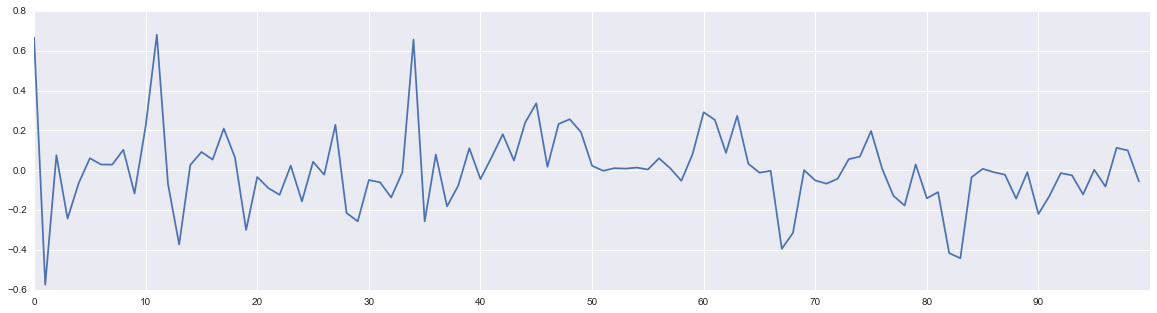

In [16]:
corrs=[]
for i in range(cheb_avg_embed[0].shape[1]):
    for j in range(corr_avg_embed[0].shape[1]):
        corrs.append(sp.stats.pearsonr(cheb_avg_embed[0][:,i], corr_avg_embed[0][:,j])[0])

fig=plt.figure(figsize=(20,5))
plt.plot(corrs)
plt.xticks(np.arange(0,100,10));

In [17]:
print 'cheb 0', 'corr 0', sp.stats.pearsonr(cheb_avg_embed[0][:,0], corr_avg_embed[0][:,0])
print 'cheb 0', 'corr 1', sp.stats.pearsonr(cheb_avg_embed[0][:,0], corr_avg_embed[0][:,1])
print 'cheb 1', 'corr 1', sp.stats.pearsonr(cheb_avg_embed[0][:,1], corr_avg_embed[0][:,1])

#print 'cheb 2', 'corr 5', sp.stats.pearsonr(cheb_avg_embed[0][:,2], corr_avg_embed[0][:,3])

cheb 0 corr 0 (0.66560000941228981, 2.6547603672247059e-09)
cheb 0 corr 1 (-0.57431577521178268, 8.5854507250065167e-07)
cheb 1 corr 1 (0.68003628624831514, 8.8119182088641964e-10)


## clustering

In [310]:
fc_cluster = [] 
cluster_labels = []
for k in [2,3,4,5,6,7,8,9,10]:
    fc_cluster.append(kmeans(corr_avg_embed[0], k))
    cluster_labels_k = []
    for l in np.unique(fc_cluster[k-2]):
        cluster = []
        for w in np.where(fc_cluster[k-2]==l)[0]:
            cluster += combined_windows[w]
        cluster_labels_k.append(cluster)
    cluster_labels.append(cluster_labels_k)

In [311]:
cluster_profiles = []
for k in [2,3,4,5,6,7,8,9,10]:
    cluster_k_profiles = []
    for cluster in cluster_labels[k-2]:
        coeff, poly = chebapprox(profiles[cluster], degree=4)
        cluster_k_profiles.append(coeff)
    cluster_profiles.append(cluster_k_profiles)

In [426]:
nk=7

In [427]:
means = {}

for c in range(len(cluster_profiles[nk-2])):
    means[c] = np.mean(cluster_profiles[nk-2][c][:,0])
sorted_means = sorted(means.items(), key=operator.itemgetter(1))

sorted_plot_list=[]
sorted_cluster_list=[]
sorted_pal=[]
for m in range(len(sorted_means)):
    sorted_plot_list+=list(cluster_profiles[nk-2][sorted_means[m][0]][:,0])
    sorted_cluster_list+=len(list(cluster_profiles[nk-2][sorted_means[m][0]][:,0]))*[('k%s'%str(sorted_means[m][0]+1))]
    sorted_pal.append(sns.color_palette('cubehelix', nk)[sorted_means[m][0]])
    
sorted_plot_df=pd.DataFrame(columns=['coeff 0', 'cluster'])
sorted_plot_df['coeff 0']=sorted_plot_list
sorted_plot_df['cluster']=sorted_cluster_list

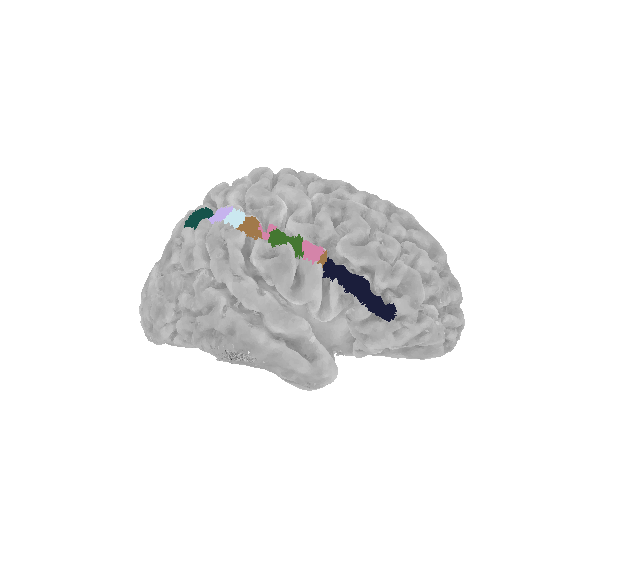

In [428]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(cluster_labels[nk-2]), cpal=sns.color_palette('cubehelix', nk), bg_map=sulc,
                     elev=180,azim=-20, figsize=(11,10), darkness=0.8)

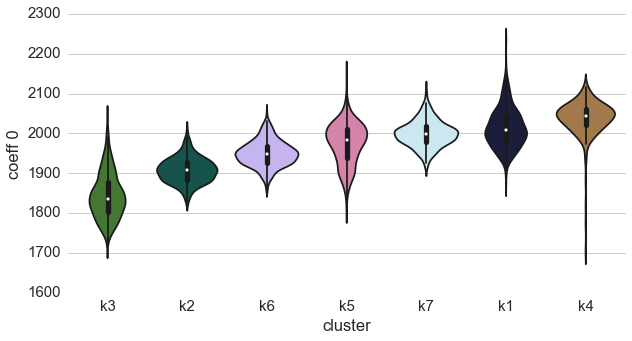

In [429]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
fig = plt.figure(figsize=(nk+3,5))
sns.violinplot(x='cluster', y='coeff 0',data=sorted_plot_df, palette=sorted_pal, inner='box', saturation=1)
sns.despine(left=True, bottom=True)

# Do this based on all coefficients

In [430]:
jsd_mat = np.zeros((nk, nk))
for i in range(nk):
    for j in range(nk):
        _, jsd_mat[i][j]=jensenshannon([np.asarray(cluster_profiles[nk-2][i][:,0]), np.asarray(cluster_profiles[nk-2][j][:,0])])

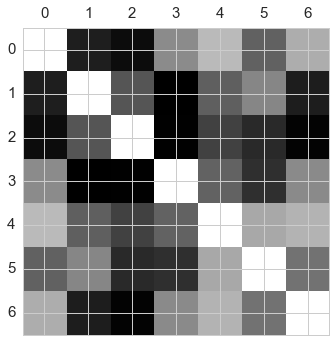

In [432]:
plt.matshow(jsd_mat)

## coefficients and profiles

In [188]:
corr_embed_dict={}
cheb_embed_dict={}
for cw in range(len(combined_windows)):
    corr_embed_dict[cw]=corr_avg_embed[0][:,1][cw]
    cheb_embed_dict[cw]=cheb_avg_embed[0][:,1][cw]
    
sorted_corr_embed = sorted(corr_embed_dict.items(), key=operator.itemgetter(1))
sorted_cheb_embed = sorted(cheb_embed_dict.items(), key=operator.itemgetter(1))

sorted_corr_embed_vals=[y for (x,y) in sorted_corr_embed]
sorted_cheb_embed_vals=[y for (x,y) in sorted_cheb_embed]
sorted_corr_embed_keys=[x for (x,y) in sorted_corr_embed]
sorted_cheb_embed_keys=[x for (x,y) in sorted_cheb_embed]

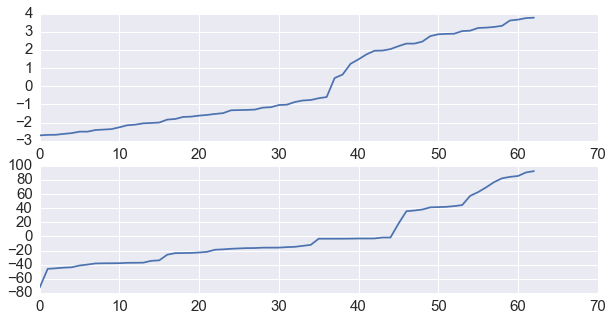

In [214]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
plt.plot(sorted_corr_embed_vals)
fig.add_subplot(212)
plt.plot(sorted_cheb_embed_vals)

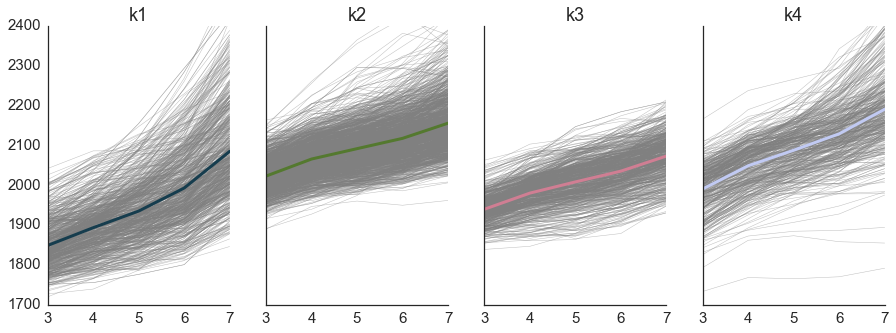

In [380]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
sol=4
x=[3,4,5,6,7]
fig = plt.figure(figsize=(15,5))
for i in range(sol):
    ax = fig.add_subplot(1,sol,i+1)
    ax.set_ylim([1700, 2400])
    for pro in cluster_profiles[sol-2][i]:
        plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), pro),color='gray', alpha=0.5, linewidth=0.5)
    plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), np.mean(cluster_profiles[sol-2][i], axis=0)), 
                                                       color=sns.color_palette('cubehelix',sol)[i], linewidth=3)
    plt.xticks([3,4,5,6,7])
    if i>0:
        plt.yticks([])
    plt.title('k'+str(i+1))
sns.despine()

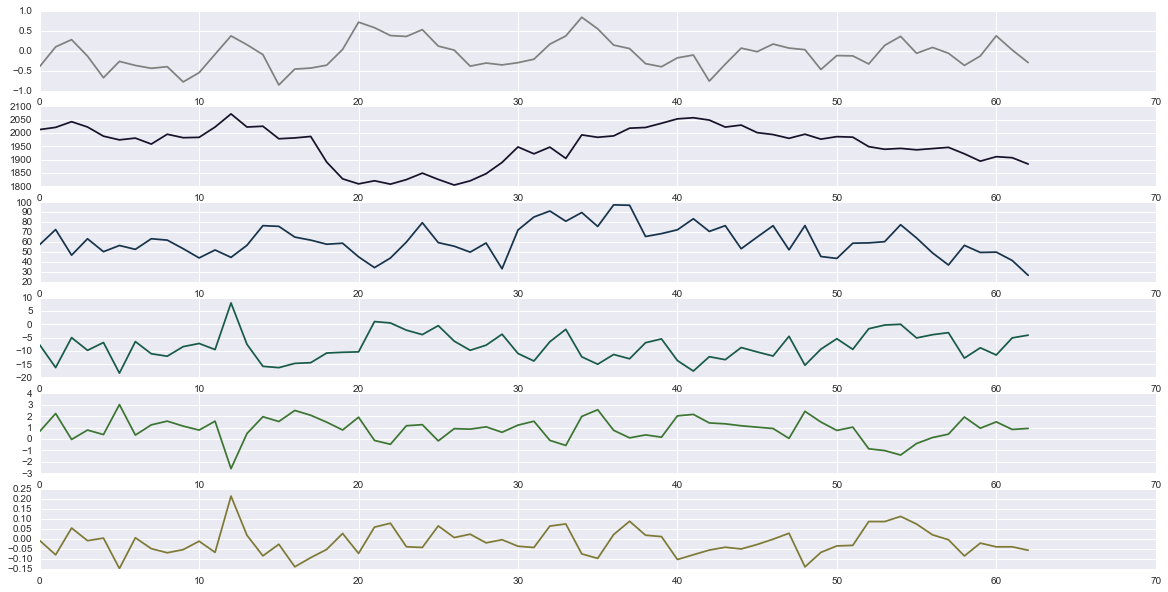

In [244]:
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sulc_avg, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

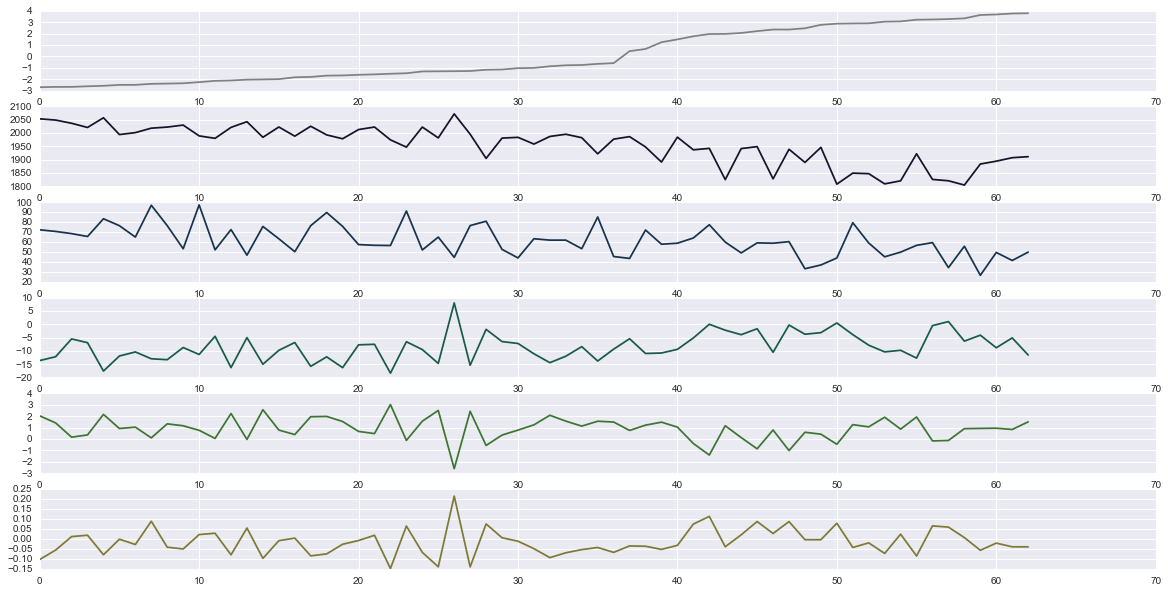

In [250]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_corr_embed])
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sorted_corr_embed_vals, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(sorted_cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

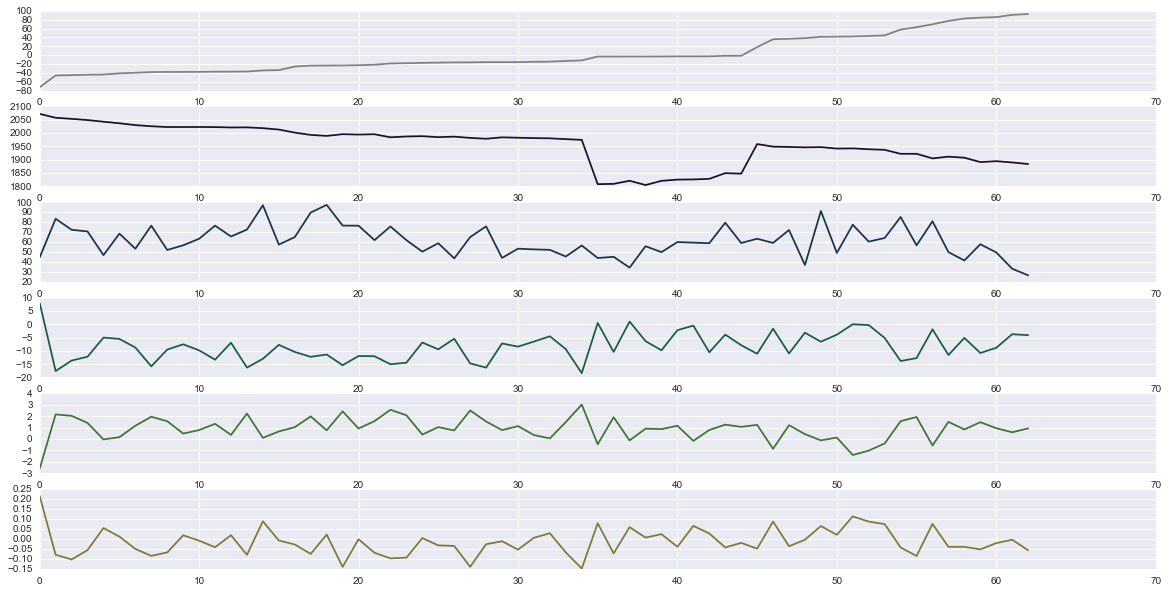

In [249]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_cheb_embed])
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sorted_cheb_embed_vals, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(sorted_cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

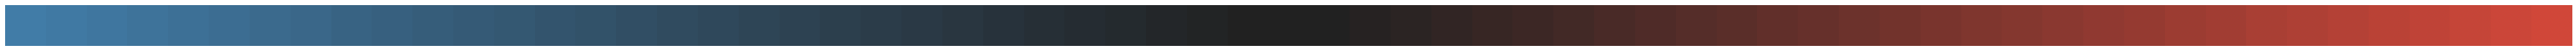

In [389]:
div_cmap, _ = make_div_cmap(len(combined_windows))
sns.palplot(div_cmap)

In [390]:
sorted_combined_windows=[]
for key in sorted_corr_embed_keys:
    sorted_combined_windows.append(combined_windows[key])

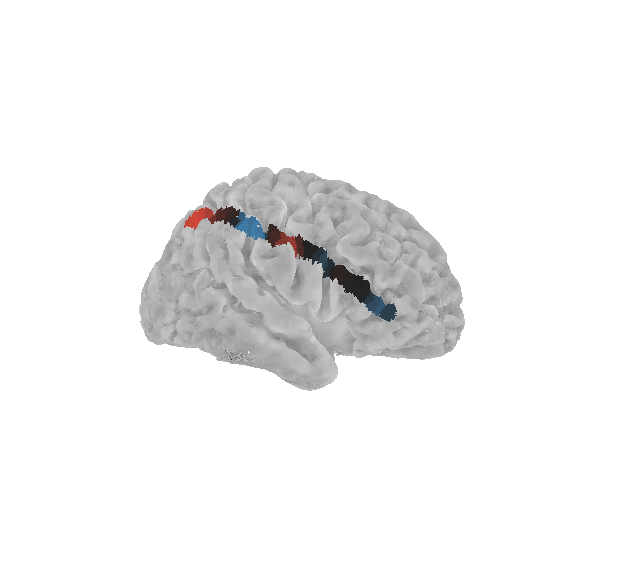

In [391]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(sorted_combined_windows), cpal=div_cmap, bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)

In [392]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_corr_embed])

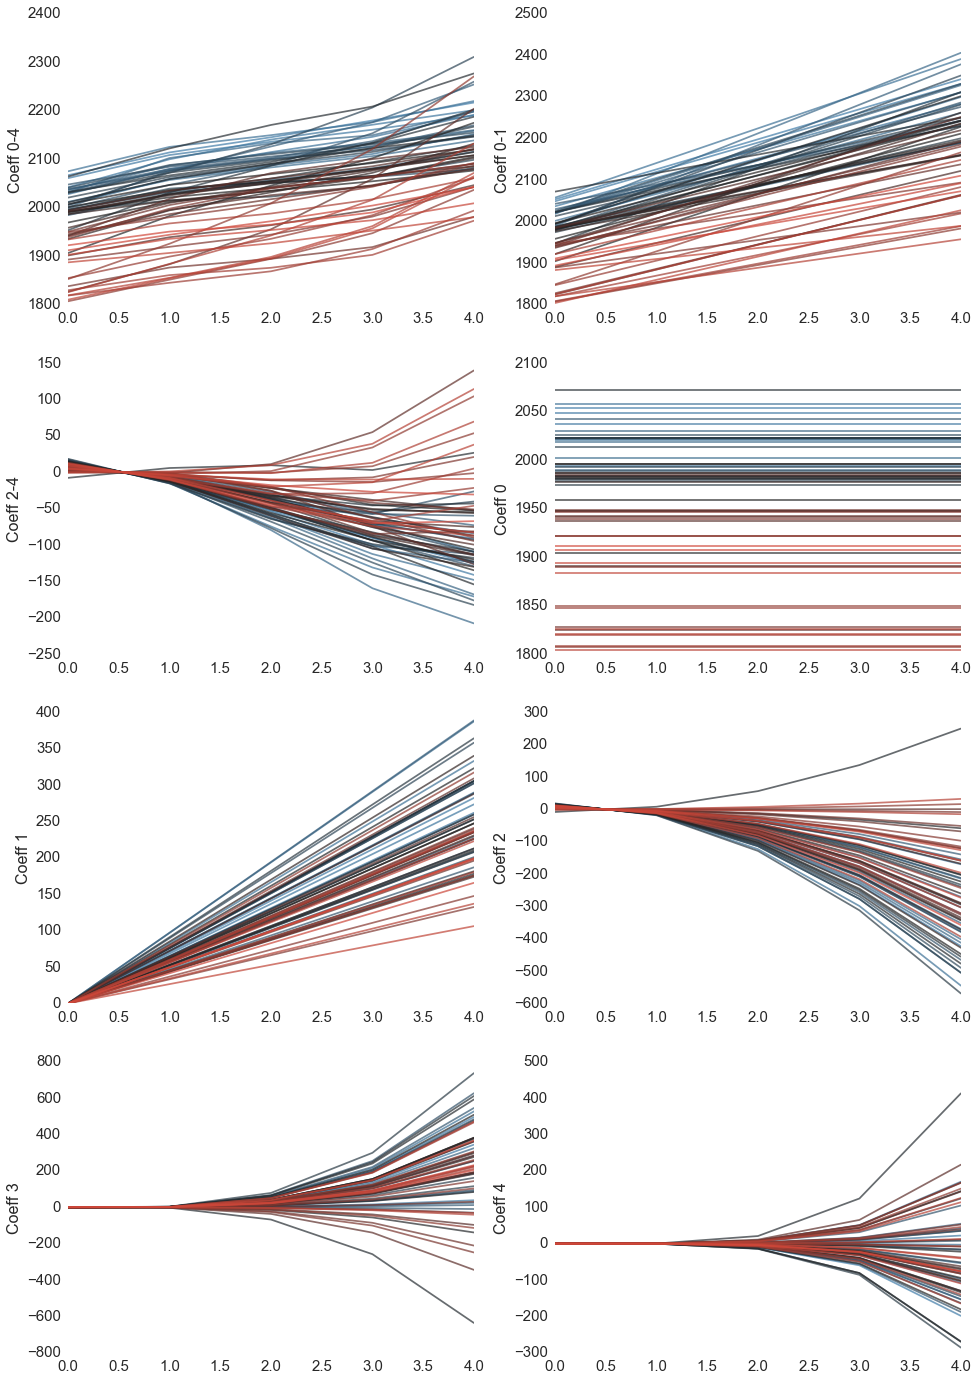

In [394]:
sns.set_style('white')
alpha=0.7
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(16,24))

###################################################################################
fig.add_subplot(421)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0], 
                                                           sorted_cheb_avg[w][1], 
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-4', fontsize=16)

###################################################################################
fig.add_subplot(422)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0],
                                                           sorted_cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-1', fontsize=16)


###################################################################################
fig.add_subplot(423)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2-4', fontsize=16)


###################################################################################
fig.add_subplot(424)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0],
                                                          0,0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0', fontsize=16)

###################################################################################
fig.add_subplot(425)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 
                                                           sorted_cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 1', fontsize=16)

###################################################################################
fig.add_subplot(426)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2],
                                                          0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2', fontsize=16)

###################################################################################
fig.add_subplot(427)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,
                                                           sorted_cheb_avg[w][3],
                                                          0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 3', fontsize=16)

###################################################################################
fig.add_subplot(428)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 4', fontsize=16)

###################################################################################
sns.despine(left=True, bottom=True)

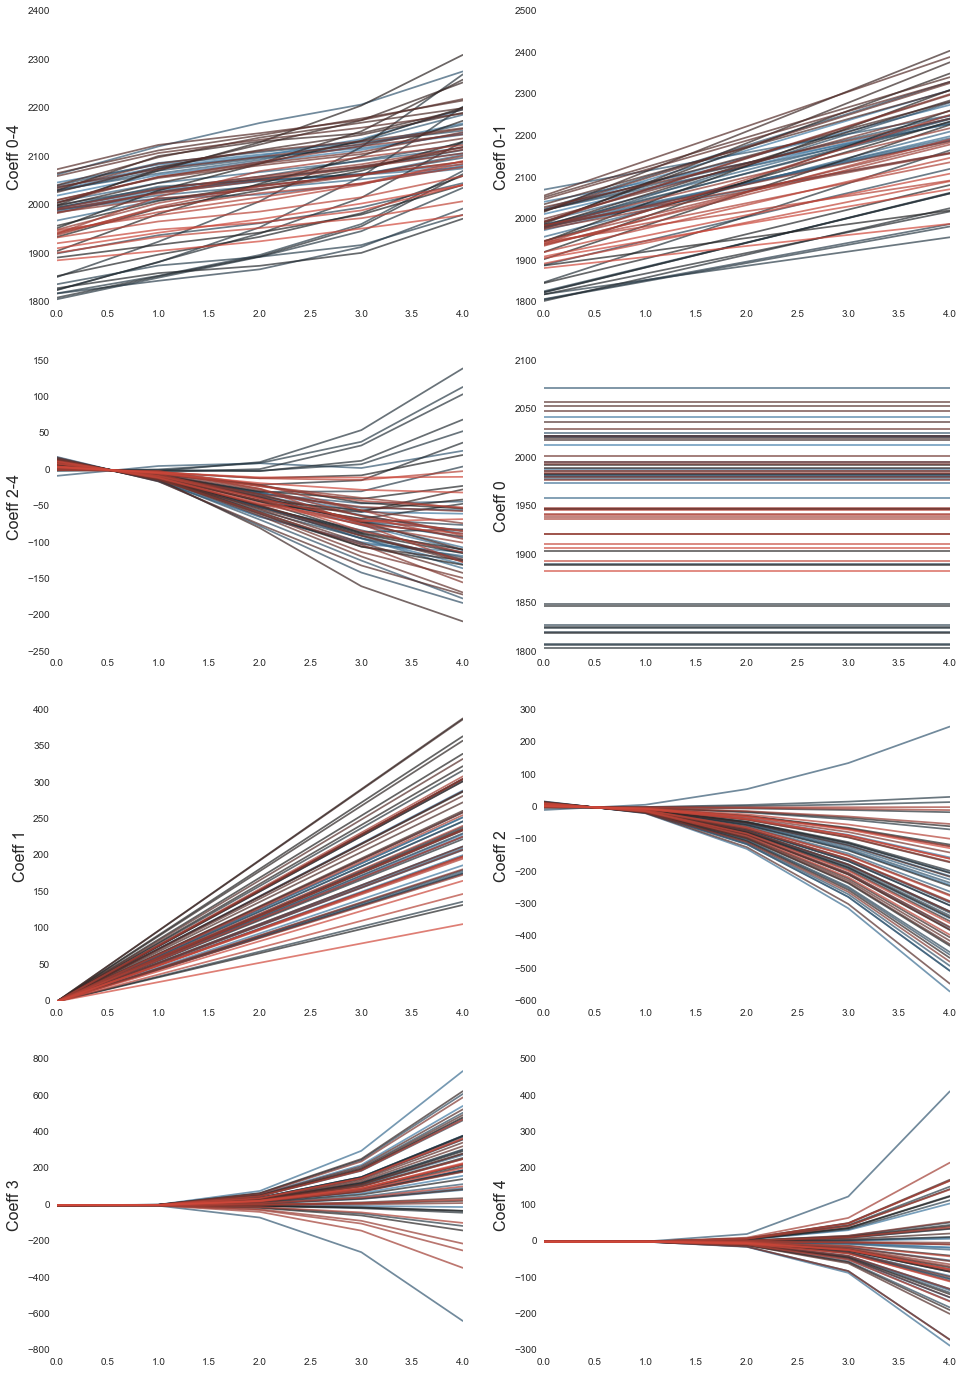

In [272]:
sns.set_style('white')
alpha=0.7
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(16,24))

###################################################################################
fig.add_subplot(421)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], 
                                                           cheb_avg[w][1], 
                                                           cheb_avg[w][2],
                                                           cheb_avg[w][3], 
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-4', fontsize=16)

###################################################################################
fig.add_subplot(422)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],
                                                           cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-1', fontsize=16)


###################################################################################
fig.add_subplot(423)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           cheb_avg[w][2],
                                                           cheb_avg[w][3], 
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2-4', fontsize=16)


###################################################################################
fig.add_subplot(424)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],
                                                          0,0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0', fontsize=16)

###################################################################################
fig.add_subplot(425)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 
                                                           cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 1', fontsize=16)

###################################################################################
fig.add_subplot(426)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           cheb_avg[w][2],
                                                          0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2', fontsize=16)

###################################################################################
fig.add_subplot(427)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,
                                                           cheb_avg[w][3],
                                                          0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 3', fontsize=16)

###################################################################################
fig.add_subplot(428)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 4', fontsize=16)

###################################################################################
sns.despine(left=True, bottom=True)

## modularity

In [21]:
import networkx as nx
import community as com

In [78]:
fc_graph = nx.from_numpy_matrix(corr_avg_affinity)
fc_part = com.best_partition(fc_graph)
fc_mod = com.modularity(fc_part, fc_graph)
fc_dendr = com.generate_dendogram(fc_graph)

print 'modularity', fc_mod
print 'modules', len(np.unique(fc_part.values()))

modularity 0.470104227049
modules 4


In [51]:
fc_mod_surf = np.zeros_like(v[:,0])
for w in fc_part.keys():
    fc_mod_surf[combined_windows[w]] = fc_part[w]+1
    
fc_mod_labels = []
for l in np.unique(fc_mod_surf):
    if l > 0:
        fc_mod_labels.append(list(np.where(fc_mod_surf==l)[0]))

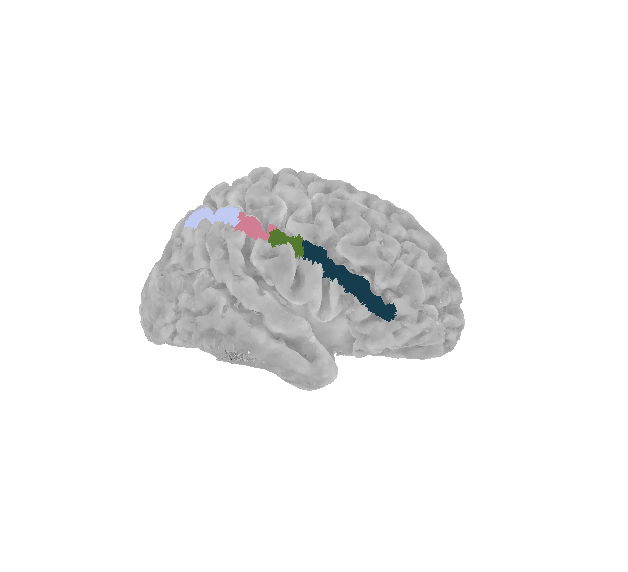

In [54]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(fc_mod_labels), cpal=sns.color_palette('cubehelix', 4), bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)

In [57]:
t1_graph = nx.from_numpy_matrix(cheb_avg_affinity)
t1_part = com.best_partition(t1_graph)
t1_mod = com.modularity(t1_part, t1_graph)
t1_dendr = com.generate_dendogram(t1_graph)

print 'modularity', t1_mod
print 'modules', len(np.unique(t1_part.values()))

modularity 0.648964690671
modules 7


In [77]:
np.unique(com.partition_at_level(t1_dendr,len(t1_dendr)-1).values())

array([0, 1, 2, 3, 4, 5, 6])

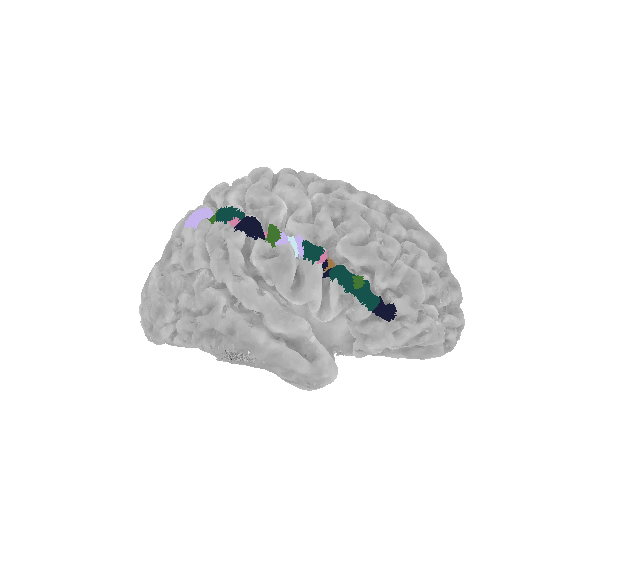

In [56]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(t1_mod_labels), cpal=sns.color_palette('cubehelix', 7), bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)